In [1]:
%matplotlib inline
%matplotlib nbagg

from typing import *
from IPython.display import Image, display, clear_output

import math
import numpy as np
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from collections import defaultdict
from typing import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device="cpu"
print(f">> Using device: {device}")

>> Using device: cuda:0


# 1. Introduction

##  1.1) Load data

Load the EEG data using our dataloader. The python scipt for generating dataset can be found in the Code folder, as well as a dataloader function building on work done by David Enslev s123997. The batch_loader is a function for class made for loading our dataset.

In [2]:
from Code.Dataloader import batch_loader
Data_train_path=r"C:/Users/Andre/Desktop/VAE/Fourier_0_overlab_70_30_split_train"
Data_validation_path=r"C:/Users/Andre/Desktop/VAE/Fourier_0_overlab_70_30_split_validation"

train_set=batch_loader(Data_train_path,device)
train_set.pre_load()
print(f"Windows in train set {train_set.data_size}")

validation_set=batch_loader(Data_validation_path,device)
validation_set.pre_load()
print(f"Windows in test set {validation_set.data_size}")


Windows in train set 6246
Windows in test set 2412


# 2. VAE Implementation

We made a pipeline for training VAE models, that can be found in the code as Experiment_setup.py 

In [3]:
from Code.Experiment_setup import VEA_experiment

In [4]:
#Difine some paths for saving the results
save_path=r"Final/"
Experiment_name=r"Final_experiment"

## 2.1 Setting up the model

In [5]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """

    def __init__(self, mu: Tensor, log_sigma: Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()

    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()

    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()

    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z = self.mu + self.sigma * self.sample_epsilon()
        return z

    def log_prob(self, z: Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        normal_dist = torch.distributions.normal.Normal(self.mu, self.sigma)
        return normal_dist.log_prob(z)


class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """

    def __init__(self,vi, input_shape, latent_features: int) -> None:
        super(VariationalAutoencoder, self).__init__()
        self.vi=vi
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.flaten=True

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=4750, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2 * latent_features)  # <- note the 2*latent_features
        )

        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=4750*2)
        )

        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2 * latent_features])))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, x: Tensor, z=False):
        loss, diagnostics, outputs = self.vi(self, x) #Replace VAE wiht self
        if z:
            pz = outputs['pz']
            return pz.sample()
        px = outputs['px']
        return px.sample()

    def posterior(self, x: Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""

        # compute the parameters of the posterior
        h_x = self.encode(x)
        mu, log_sigma = h_x.chunk(2, dim=-1)

        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def prior(self, batch_size: int = 1) -> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)

        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def observation_model(self, z: Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""

        h_z = self.decoder(z)
        h_z = h_z.view(-1, *self.input_shape)
        mu, log_sigma = h_z.chunk(2, dim=0)
        sigma = log_sigma.exp()

        return torch.distributions.normal.Normal(mu, sigma)

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        # flatten the input
        if self.flaten:
            x = x.view(x.size(0), -1)

        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)

        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))

        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}

    def sample_from_prior(self, batch_size: int = 100):
        """sample z~p(z) and return p(x|z)"""

        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)

        # sample the prior
        z = pz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self, x: Tensor, beta=1):
        _, diagnostics, _ = self.vi(self, x) #Replace VAE wiht self

        return diagnostics['elbo']


def reduce(x: Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)


class VariationalInference(nn.Module):
    def __init__(self, beta: float = 1.):
        super().__init__()
        self.beta = beta

    def forward(self, model: nn.Module, x: Tensor) -> Tuple[Tensor, Dict]:
        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]

        self.test = px.sample()

        # evaluate log probabilities
        self.px_log = px.log_prob(x)
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))

        # compute the ELBO with and without the beta parameter:
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl  # <- your code here
        beta_elbo = log_px - self.beta * kl  # <- your code here

        # loss
        loss = -beta_elbo.mean()

        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px': log_px, 'kl': kl}

        return loss, diagnostics, outputs

In [6]:
#Difine hyper paremeters
batch_size=32
n_batches=10  #How many batches for each epochs
latent_features=2 #Number of dimensions on latent layer
beta=1

VAE_EX=VEA_experiment(Data_loader_train=train_set,Data_loader_validation=validation_set,batch_size=batch_size,
                  n_batches=n_batches,latent_features=latent_features,beta=beta)
#VAE_EX.make_logfile(save_path+Experiment_name+"_log.txt","Test")

#### Plot raw data and untrained data

<IPython.core.display.Javascript object>


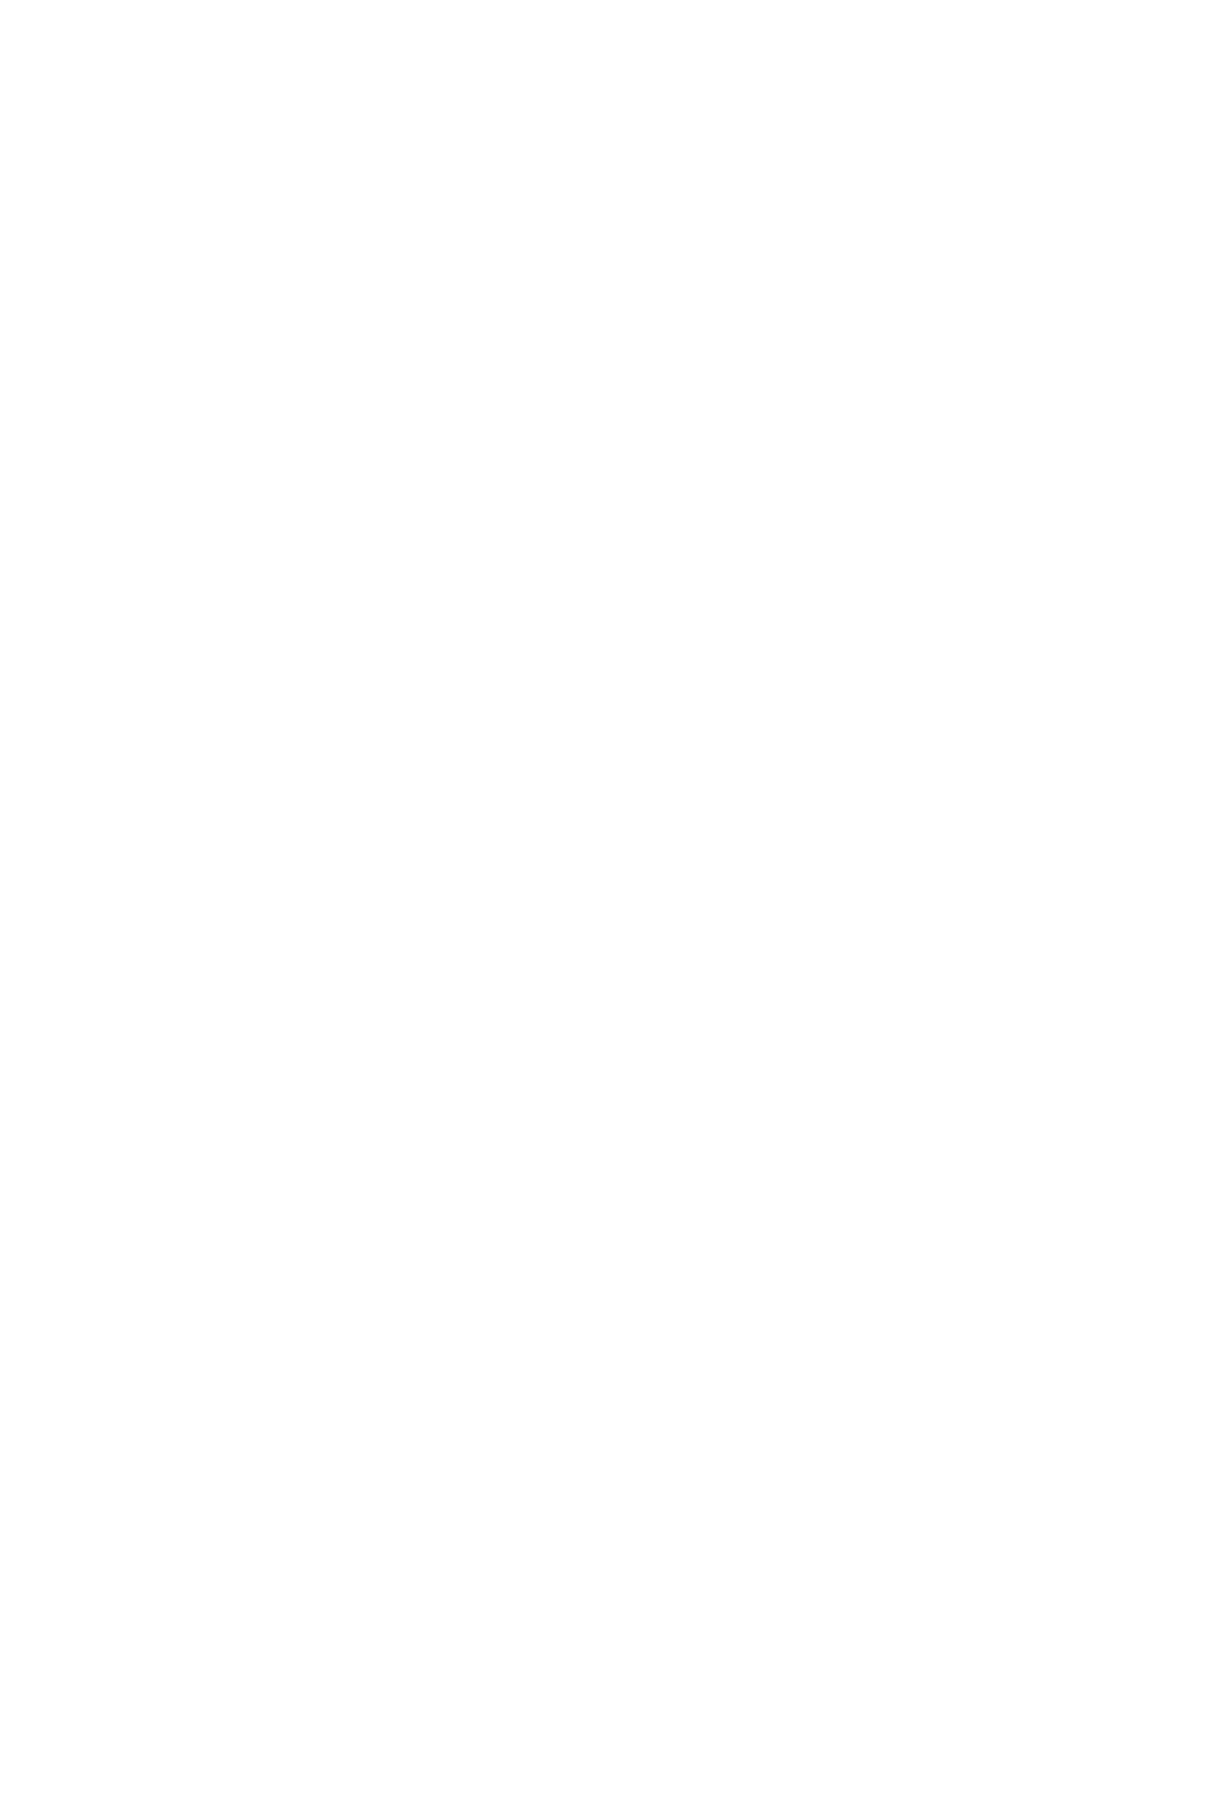

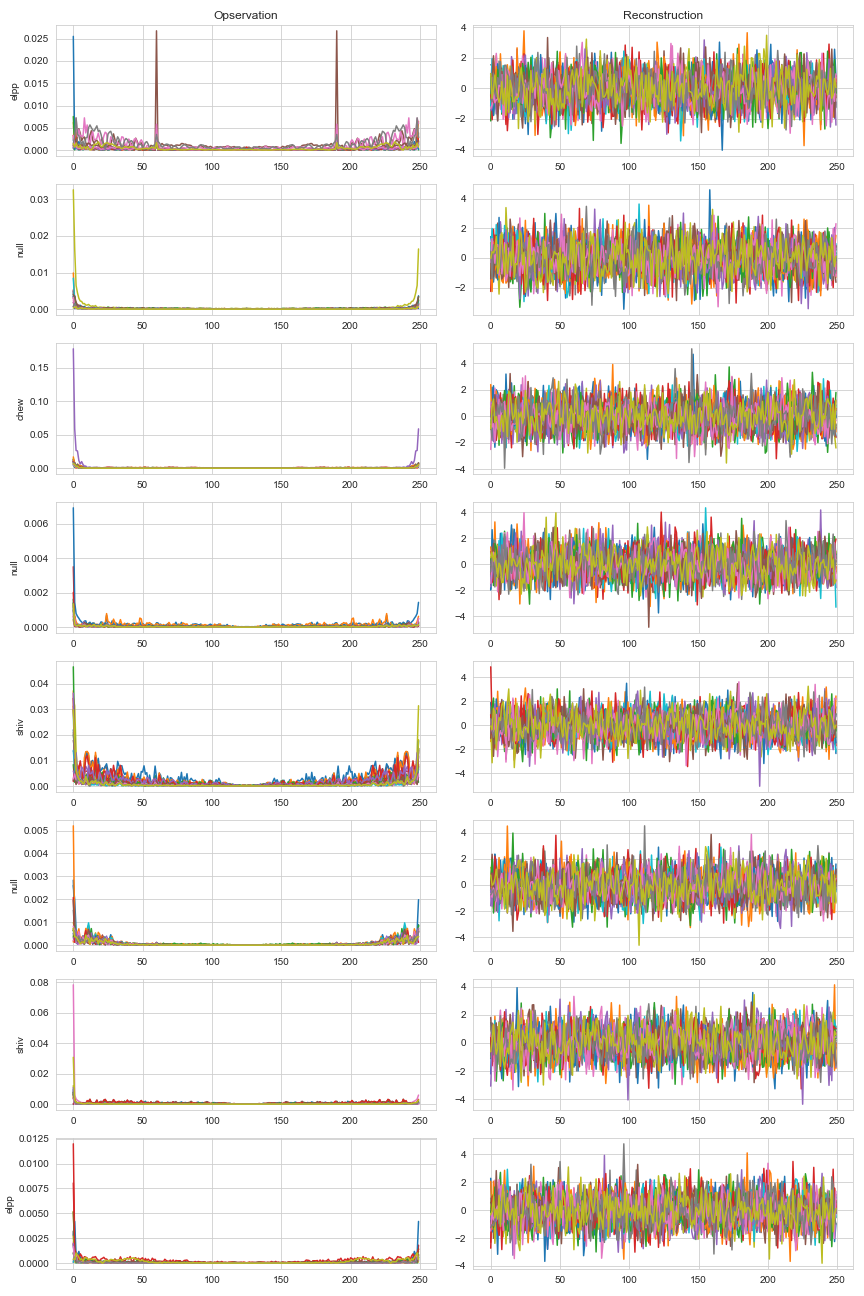

In [8]:
from Code.MNEplotter import plot_batch
X,Y,meta=validation_set.load_random(8,encoded=False)
X_new=VAE_EX.VAE.sample(X)
plot_batch(X.cpu(),X_new.cpu(),Y,show=True)

## 2.2 training the model

Epoch 0/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100


<IPython.core.display.Javascript object>


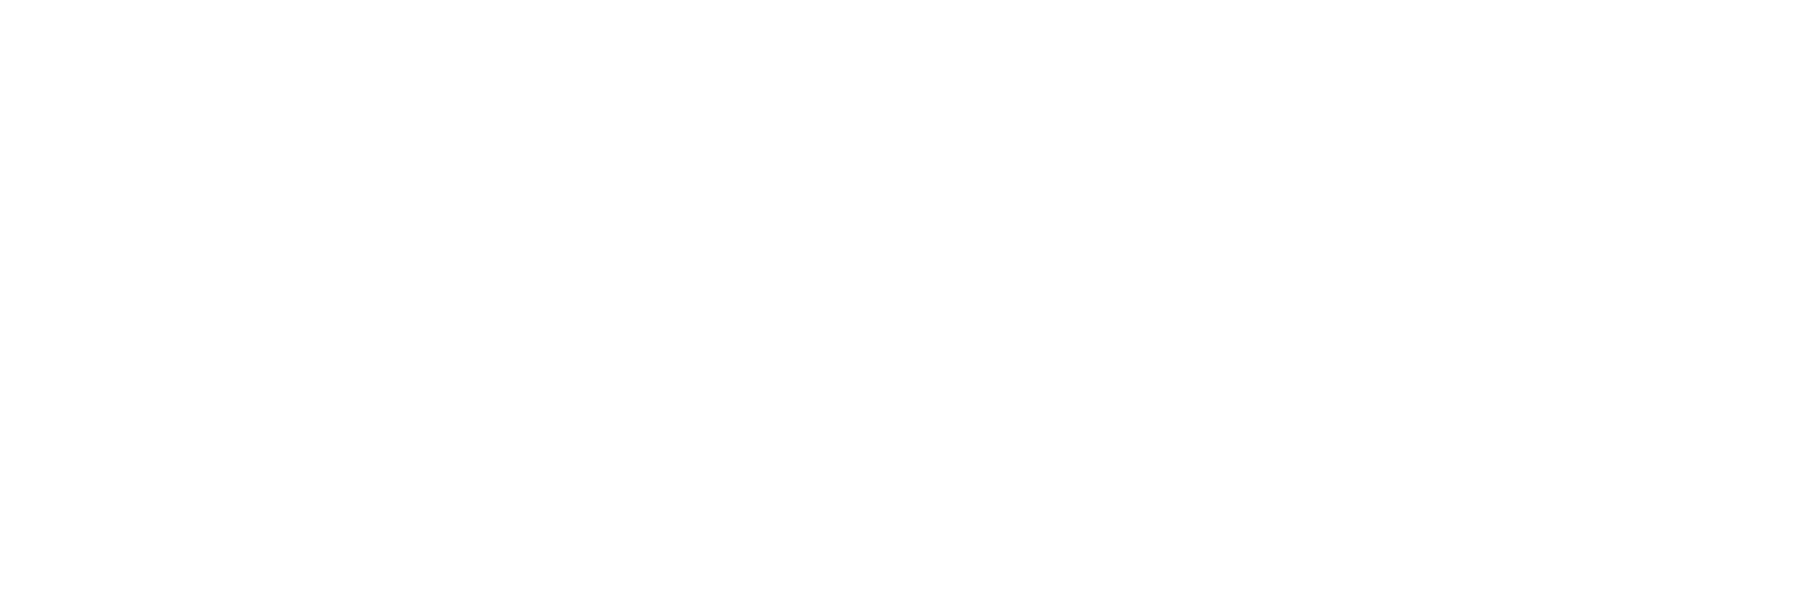

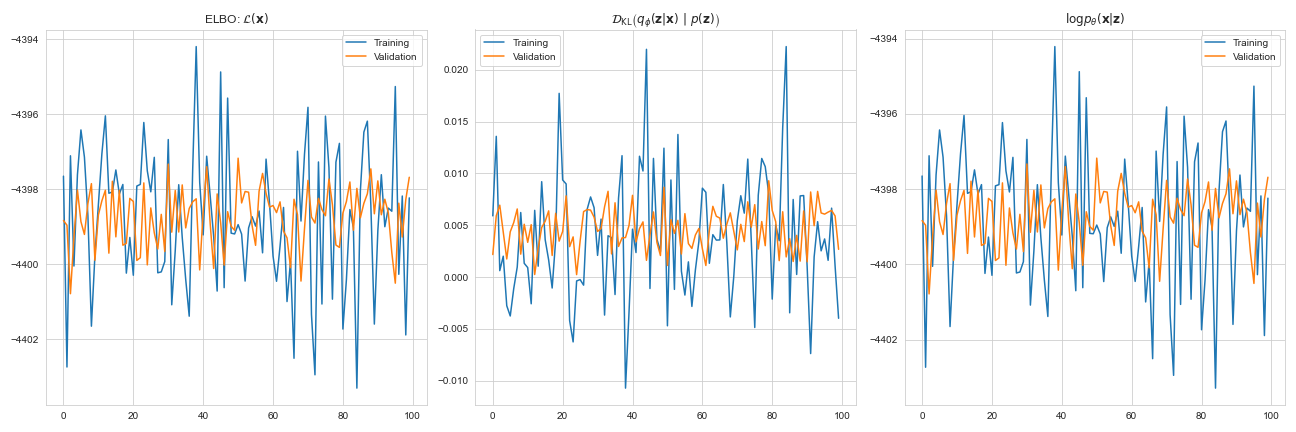

In [9]:
n_epoke=100
VAE_EX.run(num_epochs=n_epoke)
VAE_EX.plot_history(save_path+Experiment_name+"_history.png")
display(Image(save_path+Experiment_name+"_history.png"))

Save the model or load an old one.

In [10]:

# save model
torch.save(VAE_EX.VAE.state_dict(), save_path+Experiment_name+"_model.pt")


In [25]:

# load prtained model
VAE_EX.VAE.load_state_dict(torch.load(save_path+Experiment_name+"_model.pt"))


<All keys matched successfully>

### 5.(Report)Evaluate the trained model on the test set and report the number.

 

<IPython.core.display.Javascript object>


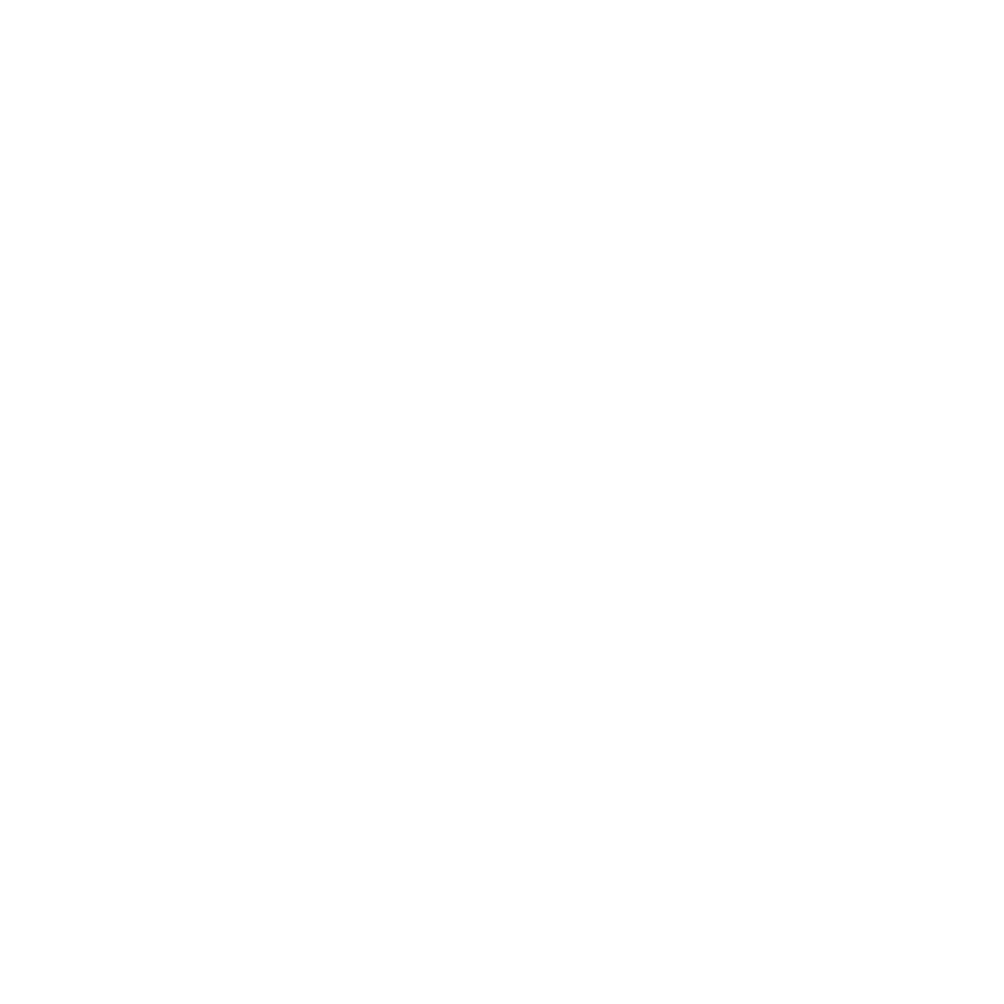

torch.Size([32, 2])


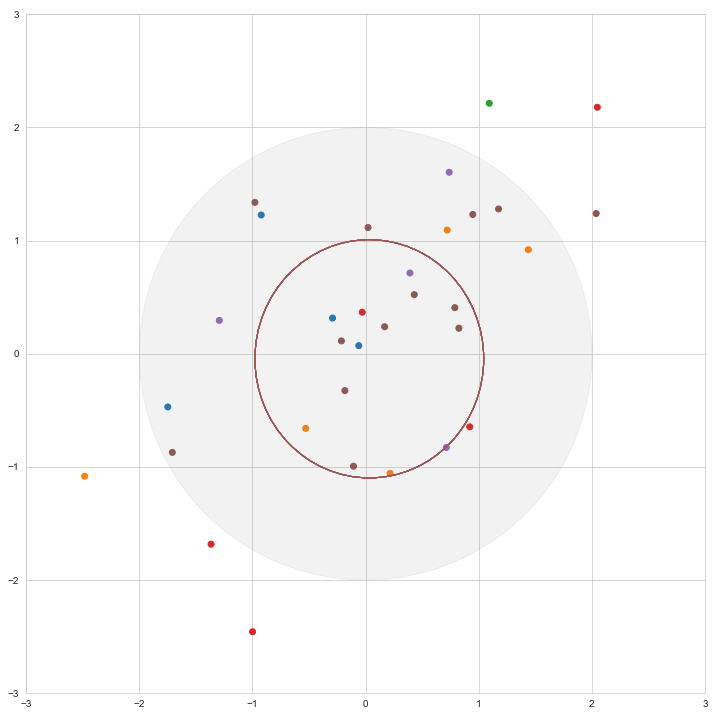

In [11]:
#Evaluate latent space
VAE_EX.show_plots(32)

<IPython.core.display.Javascript object>


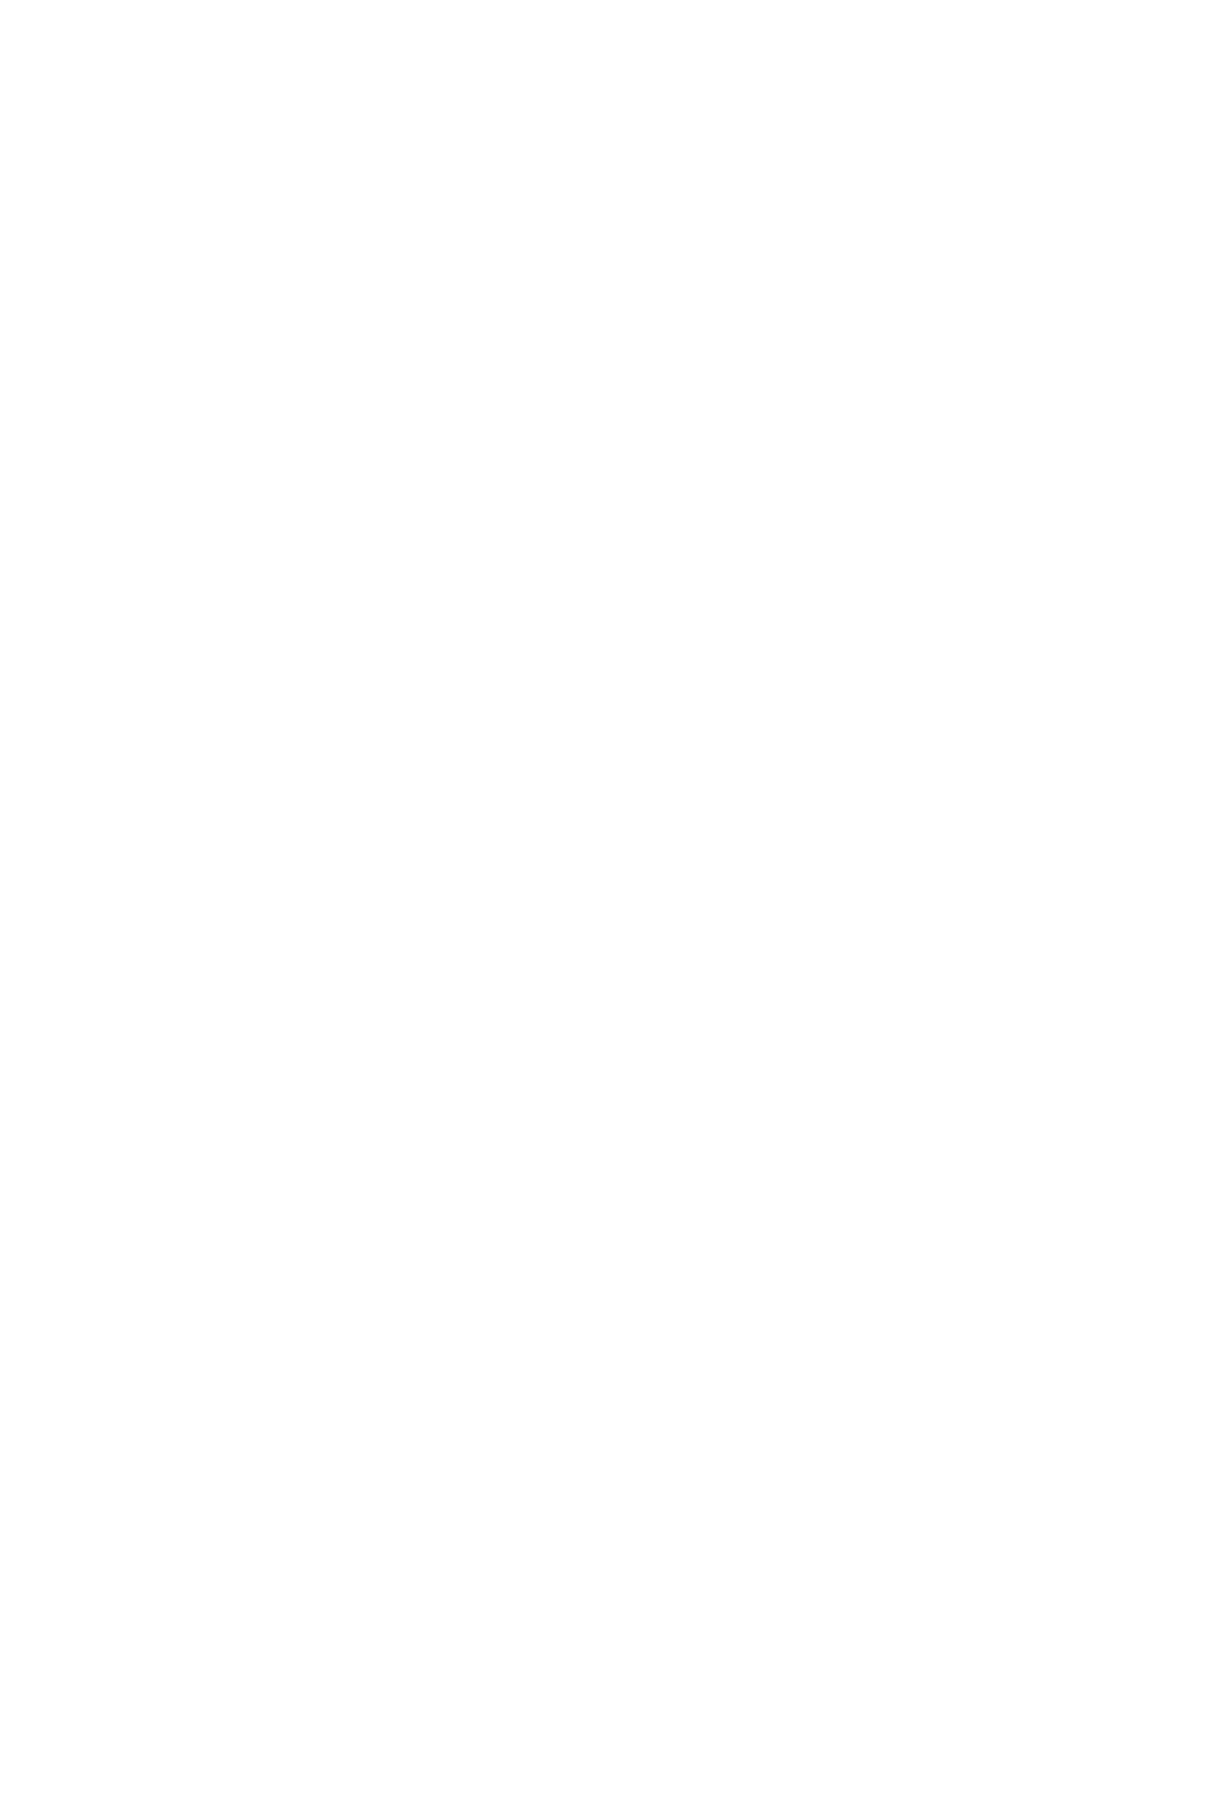

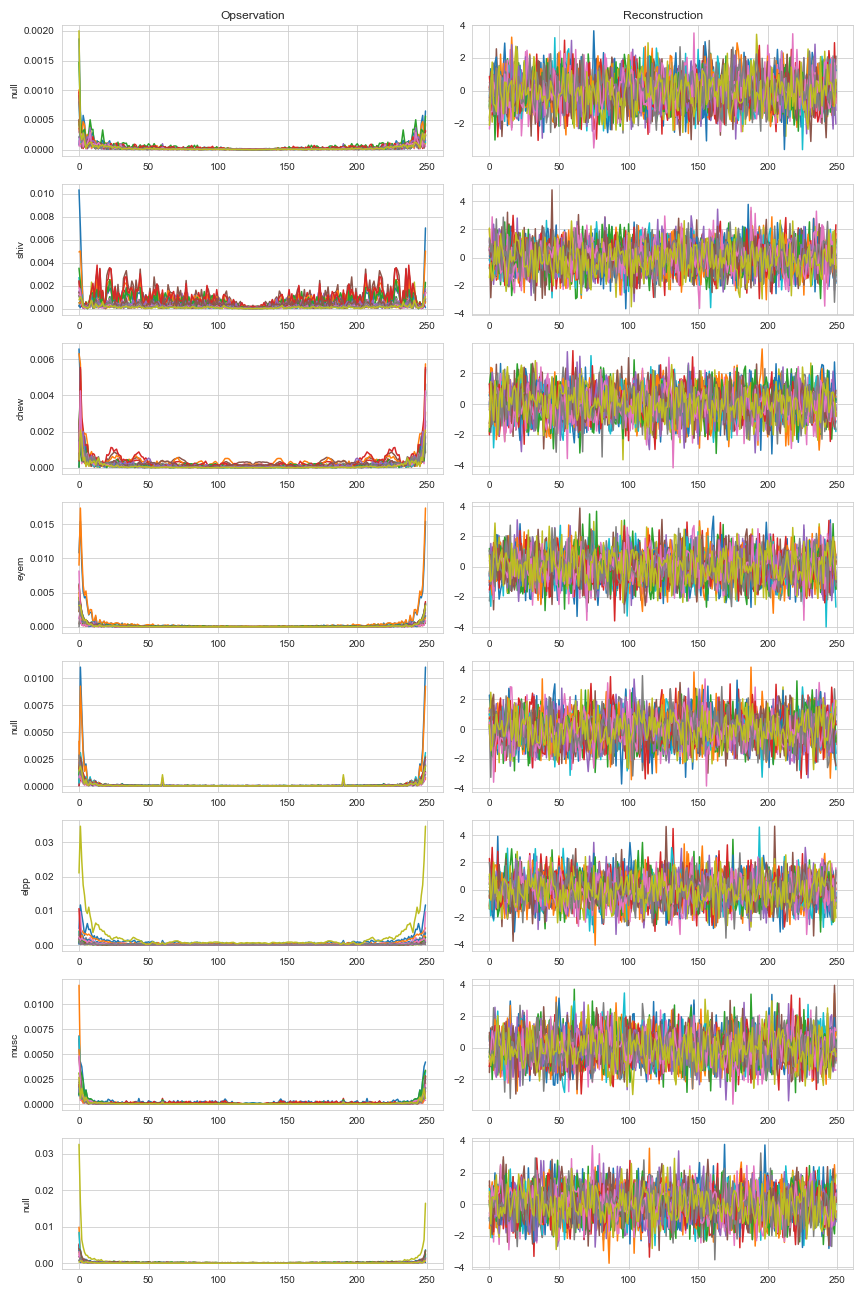

In [12]:
#Plot a sample and its reconstrution

X,Y,meta=validation_set.load_random(8,encoded=False)
X_new=VAE_EX.VAE.sample(X)
plot_batch(X.cpu(),X_new.cpu(),Y,show=True)
#plot_samples(X.cpu(),"")
#plot_samples(untrained_samples.cpu(),"")

### 2. Train different classifier on their latent representation. 

In [13]:
#Move VAE and load data to cpu.
device="cpu"
VAE=VAE_EX.VAE.cpu()
train_set.device=device
validation_set.device=device

In [14]:
#Load data and make latent representation
x_train,y_train,meta_train=train_set.load_all(encoded=False)
z_train=VAE.sample(x_train,z=True)

x_val,y_val,meta_val=validation_set.load_all(encoded=False)
z_val = VAE.sample(x_val, z = True)

In [15]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sn
import matplotlib.pyplot as plt
def evaluate(y_true, y_pred, print_cm=False, print_err=False):
    
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    names = ["null","eyem","chew","shiv","elpp","musc"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        ax=plt.subplots()
        sn.heatmap(cm, annot=True, xticklabels=names, yticklabels=names, cmap = 'Reds', fmt = 'd')
        #ax.set_xlabel('Predicted');
        #ax.set_ylabel('True'); 
        

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    if print_err:
        print("")
        print("accuracy:", accuracy)
        print("precision:", precision)
        print("recall:", recall)
        print("f1 score:", f1)
        
    return [accuracy,precision,recall,f1]

### a) Linear classifier: SVM

<IPython.core.display.Javascript object>


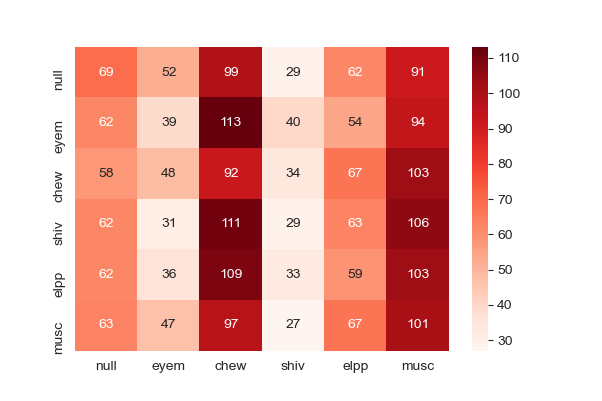


accuracy: 0.1612769485903814
precision: 0.1541501976284585
recall: 0.09701492537313433
f1 score: 0.11908396946564886


In [16]:
from sklearn import svm

clf = svm.SVC() 
SVM = clf.fit(z_train,y_train)
y_pred = SVM.predict(z_val)
_=evaluate(y_val, y_pred, print_cm=True,print_err=True)

### b) Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(z_train,y_train)

RandomForestClassifier()

Evaluate

<IPython.core.display.Javascript object>


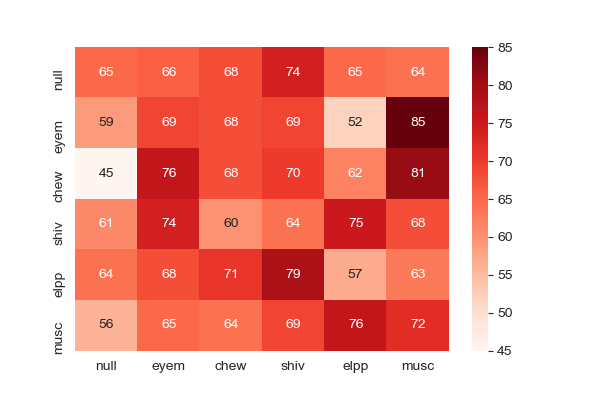


accuracy: 0.16376451077943616
precision: 0.16507177033492823
recall: 0.17164179104477612
f1 score: 0.16829268292682928


In [18]:
y_pred = RF.predict(z_val)
_=evaluate(y_val, y_pred, print_cm=True,print_err=True)

## c) Neural Network

In [19]:
#Hyperparameters
from torch.nn import Linear, BatchNorm1d
from torch.nn.functional import relu, softmax
num_classes = 6
num_hidden_l1 = 500
num_hidden_l2 = 300
num_features = z_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_output):
        super(Net, self).__init__()  
        
        self.l_1 = Linear(in_features=num_features, 
                          out_features=num_hidden_l1,
                          bias=True)
        
        self.l_2 = Linear(in_features=num_hidden_l1, 
                          out_features=num_hidden_l2,
                          bias=True)
        
        self.l_out = Linear(in_features=num_hidden_l2, 
                            out_features=num_classes,
                            bias=False)

        self.drop_layer  = nn.Dropout(0.5) # Add dropout layer

        self.batchnorm_1 = nn.BatchNorm1d(num_hidden_l1)
        self.batchnorm = nn.BatchNorm1d(num_hidden_l1)

        # define activation function in constructor

    def forward(self, x):

        x = relu(self.l_1(x))
        #x = self.drop_layer(x)
        x = relu(self.l_2(x))
       
        return softmax(self.l_out(x), dim=1)

net = Net(num_features, num_classes)
print(net)

Net(
  (l_1): Linear(in_features=2, out_features=500, bias=True)
  (l_2): Linear(in_features=500, out_features=300, bias=True)
  (l_out): Linear(in_features=300, out_features=6, bias=False)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (batchnorm_1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:

import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1.5e-3) # use Adama instead # Use L2 regularization
criterion = nn.CrossEntropyLoss()

In [21]:
#Load data with one hot encoding
x_train,y_train,meta_train=train_set.load_all(encoded=True)
y_train=torch.argmax(y_train,dim=1)
z_train=VAE.sample(x_train,z=True)

x_valid,y_valid,meta_train=train_set.load_all(encoded=True)
y_valid=torch.argmax(y_valid,dim=1)
z_valid=VAE.sample(x_valid,z=True)

Epoch  0 : Train Loss 3.225792 , Train acc 0.167147, Valid acc 0.166186
Epoch 10 : Train Loss 3.130643 , Train acc 0.166827, Valid acc 0.166827
Epoch 20 : Train Loss 3.114946 , Train acc 0.166827, Valid acc 0.166827
Epoch 30 : Train Loss 3.238300 , Train acc 0.166827, Valid acc 0.166827
Epoch 40 : Train Loss 3.133167 , Train acc 0.166827, Valid acc 0.166827
Epoch 50 : Train Loss 3.294605 , Train acc 0.173397, Valid acc 0.169551
Epoch 60 : Train Loss 3.120790 , Train acc 0.166827, Valid acc 0.166827
Epoch 70 : Train Loss 3.130112 , Train acc 0.166827, Valid acc 0.166827
Epoch 80 : Train Loss 3.246326 , Train acc 0.166827, Valid acc 0.166827
Epoch 90 : Train Loss 3.266917 , Train acc 0.166827, Valid acc 0.166827


<IPython.core.display.Javascript object>


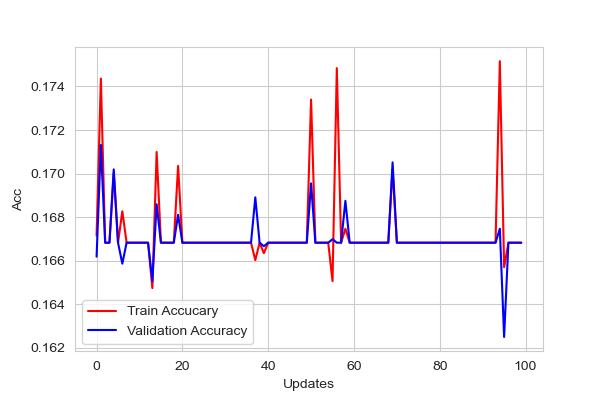

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

In [22]:

# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 60
num_epochs = 100
num_samples_train = z_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = z_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(z_train[slce]).type(torch.float)
        y_pred = torch.argmax(output, dim =1)
        
        # compute gradients given loss
        target_batch = y_train[slce].type(torch.long)

        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(z_train[slce])
        y_pred = torch.argmax(output, dim =1)
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(y_pred.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(z_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(y_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

Evaluate

<IPython.core.display.Javascript object>


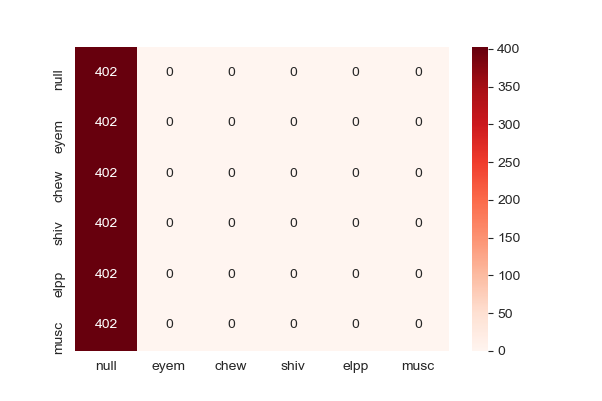


accuracy: 0.16666666666666666
precision: 0.0
recall: 0.0
f1 score: nan


C:\Users\Andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


[0.16666666666666666, 0.0, 0.0, nan]

In [23]:
y_out = net(z_val)
names = ["null","eyem","chew","shiv","elpp","musc"]
y_pred = [names[l] for l in torch.argmax(y_out, dim =1).detach().numpy()]
evaluate(y_val, y_pred, print_cm=True,print_err=True)